# Reservoirs tables - EFAS
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 25-08-2025<br>

**Introduction:**<br>

* [x] 100-year return period of inflow
* [x] average inflow
* [x] environmental flow
* [x] storage capacity
* [x] catchment area
* [ ] reservoir area: it would be necessary if we want to model the reservoir surface area
* [ ] elevation crest: it would be necessary if we want to model the reservoir level
* [ ] dam height: it would be necessary if we want to model the reservoir level

In [1]:
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from reservoirs_lshm.utils.lisflood import create_lisflood_nc
from reservoirs_lshm.utils.plots import compare_attributes
from reservoirs_lshm.utils.utils import return_period

warnings.simplefilter(action='ignore', category=FutureWarning)

## Configuration

In [2]:
# input paths
PATH_USER = Path('Z:/nahaUsers/casadje')
PATH_EFAS5 = PATH_USER / 'EFASv5'
PATH_EFAS6 = PATH_USER / 'EFASv6'
PATH_GDW = PATH_USER / 'datasets' / 'reservoirs' / 'GDW' / 'GDW_v1_0_shp'

# output paths
PATH_OUT = PATH_EFAS6 / 'reservoirs' / 'tables'
PATH_PLOTS = PATH_OUT / 'plots'
PATH_PLOTS.mkdir(parents=True, exist_ok=True)

# minimum storage capacity included in EFAS
MIN_VOLUME = 10 # hm³
MIN_CATCHMENT = 50 # km²
MIN_AREA = None # km²
MIN_DOR = 0.08 # 

## Data

### EFAS6

I load a shapefile with the manual selection of reservoirs to be included in EFASv6, which have already been located in the LISFLOOD grid.

In [3]:
# import relocated reservoirs
# reservoirs = gpd.read_file(PATH_EFAS6 / 'reservoirs' / 'reservoirEfasV6.shp')
efas6 = gpd.read_file(PATH_EFAS6 / 'reservoirs' / 'tables' / 'efas6_reservoirs+GDW_20250716.shp')
efas6.rename(columns={'RESID': 'RES_ID'}, inplace=True)

# select columns
id_cols = [col for col in efas6.columns if col.upper().endswith('ID')]
efas6[id_cols] = efas6[id_cols].replace(0, np.nan)
for col in id_cols:
    try:
        efas6[col] = efas6[col].astype('Int64')
    except:
        print(f'Could not convert to "In64" column {col}')
efas6 = efas6[id_cols + ['geometry']]
        
# assing index
efas6.set_index('GDW_ID', drop=True, inplace=True)
idx_name = efas6.index.name
efas6.sort_index(inplace=True)

print(efas6.shape)

# points of interest used to extract values from maps (coordinates from GloFAS5)
poi6 = pd.concat((efas6.geometry.x, efas6.geometry.y), axis=1)
poi6.columns = ['x', 'y']
poi6 = poi6.to_xarray()

Could not convert to "In64" column ICOLD_ID
(1542, 6)


### EFAS5

#### Reservoirs

In [4]:
efas5 = gpd.read_file(PATH_EFAS5 / 'tables' / 'EFAS5_reservoirs.shp')#.set_index('RES_ID')
efas5.rename(columns={'ResID': 'RES_ID'}, inplace=True)

# assign ID
map_res_idx = {res_id: idx for idx, res_id in efas6.RES_ID.items() if not pd.isna(res_id)}
efas5[idx_name] = efas5.RES_ID.map(map_res_idx).astype('Int64')

# filter reservoirs in EFAS5 also in EFAS6
efas5.dropna(subset=[idx_name], inplace=True)
efas5.set_index(idx_name, drop=False, inplace=True)

print(efas5.shape)

(1390, 34)


#### Static maps

In [5]:
# load the upstream area map
uparea = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'upArea_European_01min.nc').squeeze(dim='band')
# uparea = uparea.where(uparea != -999999, np.nan)
uparea = uparea.where(uparea >= 0, np.nan)
uparea /= 1e6 # km2

# local drainage direction map
ldd = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'ldd_European_01min.nc').squeeze(dim='band')

#### Natural flow

I have run the tool `ncextract` on the EFASv5 long-term run simulation with natural flow, i.e, no reservoirs and no water abstraction. The discharge files resulting from this simulation are in the HPC: `/BGFS/COMMON/casadje/EFAS5/long_run/dis/natural_flow/`.

The discharge time series extracted for the reservoir locations are proxies of the reservoir inflow. From these time series we need to estimate the 100-year return period, average inflow and environmental flow.

In [6]:
# # export CSV needed to run `ncextract`
# points = pd.concat((efas6.geometry.x, efas6.geometry.y), axis=1)
# points.columns = ['lon', 'lat']
# points.to_csv(PATH_EFAS6 / 'reservoirs' / 'ancillary' / 'ncextract' / 'reservoirs_efas6_GDW.csv', float_format='%.3f')

In [7]:
# # daily timeseries of naturalised discharge
# dis_nat = xr.open_dataset(PATH_EFAS6 / 'reservoirs' / 'ancillary' / 'ncextract' / f'nat_dis_EFAS5_1545.nc')#['dis']
# dis_nat = dis_nat.sel(time=slice('1993-01-02', None))
# dis_nat.close()

# # rename ID dimension with the indexin "efas6"
# map_id_idx = {
#     1520: 99998,
#     1537: 8795,
#     1538: 3539,
# }
# atol = 8.333e-3
# for ID, lon, lat in zip(dis_nat.ID.data, dis_nat.lon.data, dis_nat.lat.data):
#     if ID in map_id_idx:
#         continue
#     mask = np.isclose(efas6.geometry.x, lon, atol=atol) & np.isclose(efas6.geometry.y, lat, atol=atol)
#     if mask.sum() == 1:
#         map_id_idx[ID] = efas6[mask].index.item()
#     elif mask.sum() > 1:
#         print(ID, lon, lat, 'too many matches')
#     else:
#         print(ID, lon, lat, 'no matches')
# if len(map_id_idx) != len(efas6):
#     print('WARNING. The corresponding GDW_ID could not be found for all the outlets')

# # rename IDs
# dis_nat = dis_nat.sel(ID=list(map_id_idx))
# dis_nat['ID'] = [map_id_idx[ID] for ID in dis_nat.ID.data]
# dis_nat = dis_nat.rename({'ID': idx_name})

# # export individual files named after the GDW_ID
# path_out = PATH_EFAS6 / 'reservoirs' / 'ancillary' / 'ncextract' / 'nat_dis'
# for gdw_id in dis_nat.GDW_ID.data:
#     output_file = path_out / f'{gdw_id}.nc'
#     if output_file.is_file():
#         continue
#     dis_nat.sel(GDW_ID=gdw_id).to_netcdf(output_file)

In [8]:
# path_ncextract = PATH_EFAS6 / 'reservoirs' / 'ancillary' / 'ncextract' / 'natural_flow'

# # daily timeseries of naturalised discharge: outflow
# dis_nat1 = xr.open_mfdataset((path_ncextract / 'outflow').glob('*.nc'), combine='nested', concat_dim=idx_name)['dis']
# dis_nat1.close()

# # daily timeseries of naturalised discharge: inflow
# dis_nat2 = xr.open_mfdataset((path_ncextract / 'inflow').glob('*.nc'))['dis']
# dis_nat2.close()
# dis_nat2 = dis_nat2.rename({'id': 'GDW_ID'})
# dis_nat2 = dis_nat2.sel(time=slice('1993-01-02', None))

# # concatenate
# dis_nat = xr.concat([dis_nat1, dis_nat2], dim=idx_name).compute()

# # replace wrong ids
# replace_ids = {
#     50010: 50001,
#     50020: 50002,
#     50030: 50003
# }
# for old_id, new_id in replace_ids.items():
#     dis_nat['GDW_ID'] = dis_nat['GDW_ID'].where(dis_nat['GDW_ID'] != old_id, new_id)

In [14]:
# daily timeseries of naturalised discharge: inflow
path_ncextract = PATH_EFAS6 / 'reservoirs' / 'ancillary' / 'ncextract' / 'natural_flow'
dis_nat = xr.open_mfdataset((path_ncextract / 'inflow').glob('*.nc'))['dis']
dis_nat.close()
dis_nat = dis_nat.rename({'id': 'GDW_ID'})
dis_nat = dis_nat.sel(time=slice('1993-01-02', None))

In [15]:
# 10th percentile of the natural flow
dis_env_nat = xr.open_dataset(PATH_EFAS5 / 'natural_flow' / 'dis_all20_pctl10.nc')['dis'].squeeze('time')

#### Long-term run
Average discharge in the EFAS5 long-term run.

In [16]:
# average discharge
dis_avg_ltr = xr.open_dataset(PATH_EFAS5 / 'long_run' / 'disavg_1992_2023.nc').squeeze(dim='time')['dis']
dis_avg_ltr = dis_avg_ltr.rename({'lat': 'y', 'lon': 'x'})
dis_avg_ltr.rio.write_crs("EPSG:4326", inplace=True)
dis_avg_ltr.close()

# 100-year discharge
dis_100_ltr = rxr.open_rasterio(PATH_EFAS5 / 'long_run' / 'flood_threshold_efas_v5.1_rl_100.0.nc').squeeze(dim='band')

### GDW

In [17]:
# load Global Dam Watch
gdw = gpd.read_file(PATH_GDW / 'GDW_barriers_v1_0.shp').set_index('GDW_ID')
gdw['GRAND_ID'] = gdw['GRAND_ID'].replace(0, np.nan).astype('Int64')
gdw.replace(-99, np.nan, inplace=True)
cols_years = ['YEAR_DAM', 'PRE_YEAR', 'ALT_YEAR', 'REM_YEAR']
gdw[cols_years] = gdw[cols_years].astype('Int64')

# filter those in GloFAS5
gdw = gdw.loc[gdw.index.intersection(efas6.index)]
print(gdw.shape)

(1534, 71)


In [18]:
# # map IDs in GRanD and GDW
# map_grand_gdw = {}
# for grand_id in efas6.GRAND_ID:
#     mask = gdw.GRAND_ID == grand_id
#     if mask.sum() > 0:
#         map_grand_gdw[grand_id] = gdw[mask].index.item()

# # add the GDW_ID to glofas5
# efas6['GDW_ID'] = efas6.GRAND_ID.map(map_grand_gdw)
# efas6['GDW_ID'] = efas6['GDW_ID'].astype('Int64')

# # export
# efas6.to_file(PATH_EFAS6 / 'reservoirs' / 'tables' / 'efas6_reservoirs+GDW.shp')

### GRanD

In [19]:
# load raw dataset
grand = gpd.read_file(PATH_EFAS6 / 'reservoirs' / 'GRanD' / 'grand_dams.shp')
grand.replace({-99: np.nan}, inplace=True)
cols_years = ['YEAR', 'ALT_YEAR', 'REM_YEAR']
grand[cols_years] = grand[cols_years].astype('Int64')

# connection between GRAND_ID and ID
map_grand_idx = {grand_id: idx for idx, grand_id in efas6.GRAND_ID.items() if not pd.isna(grand_id)}
grand[idx_name] = grand.GRAND_ID.map(map_grand_idx).astype('Int64')
grand = grand[grand[idx_name].notnull()]
grand.set_index(idx_name, drop=True, inplace=True)

if len(grand) != efas6.GRAND_ID.notnull().sum():
    print('WARNING. Different number of reservoirs in "grand" and those in "efas6" with "GRAND_ID".')
print(grand.shape)

(1521, 62)


### ICOLD

In [20]:
# load ICOLD dataset
icold = gpd.read_file(PATH_EFAS6 / 'reservoirs' / 'ICOLD' / 'icold.shp')
icold.loc[icold.Catch_Area <= 0, 'Catch_Area'] = np.nan


# connection between ICOLD and ID
map_icold_idx = {icold_id: idx for idx, icold_id in efas6.ICOLD_ID.items() if not pd.isna(icold_id)}
icold[idx_name] = icold.Int_Code.map(map_icold_idx).astype('Int64')
icold = icold[icold[idx_name].notnull()]
icold.set_index(idx_name, drop=True, inplace=True)

if len(icold) != efas6.ICOLD_ID.notnull().sum():
    print('WARNING. Different number of reservoirs in "icold" and those in "efas6" with "ICOLD_ID".')
print(icold.shape)

(1513, 46)


### HydroLakes

In [21]:
# load HydroLakes
# hylak = gpd.read_file(PATH_EFAS6 / 'reservoirs' / 'HydroLakes' / 'hydrolakes_dams.shp').set_index('Hylak_id')
hylak = gpd.read_file(PATH_EFAS6 / 'lakes' / 'hydrolakes_domain.shp')
hylak.Grand_id = hylak.Grand_id.replace(0, np.nan)
hylak.Vol_res = hylak.Vol_res.replace(0, np.nan)

# connection between GRanD and ID
map_hylak_idx = {hylak_id: idx for idx, hylak_id in efas6.HYLAK_ID.items() if not pd.isna(hylak_id)}
hylak[idx_name] = hylak.Hylak_id.map(map_hylak_idx)
hylak = hylak[hylak[idx_name].notnull()]
hylak.set_index(idx_name, drop=True, inplace=True)

if len(hylak) != efas6.HYLAK_ID.notnull().sum():
    print('WARNING. Different number of reservoirs in "hylak" and those in "efas6" with "HYLAK_ID".')
print(hylak.shape)

(1449, 306)


## Attributes
### Capacity

In [22]:
capacity = pd.DataFrame(
    index=efas6.index, 
    columns=['EFAS5', 'GDW', 'GRAND', 'ICOLD', 'HYLAK', 'EFAS6', 'SOURCE'], 
    dtype=float
)
capacity.SOURCE = capacity.SOURCE.astype(str)

# EFAS5
capacity.loc[efas5.index, 'EFAS5'] = efas5.tstor

# GDW
capacity.loc[gdw.index, 'GDW'] = gdw.CAP_MCM

# GRanD
capacity.loc[grand.index, 'GRAND'] = grand.CAP_MCM

# ICOLD
capacity.loc[icold.index, 'ICOLD'] = icold.Res_Vol

# HydroLakes
capacity.loc[hylak.index, 'HYLAK'] = hylak.Vol_res

#### Comparison

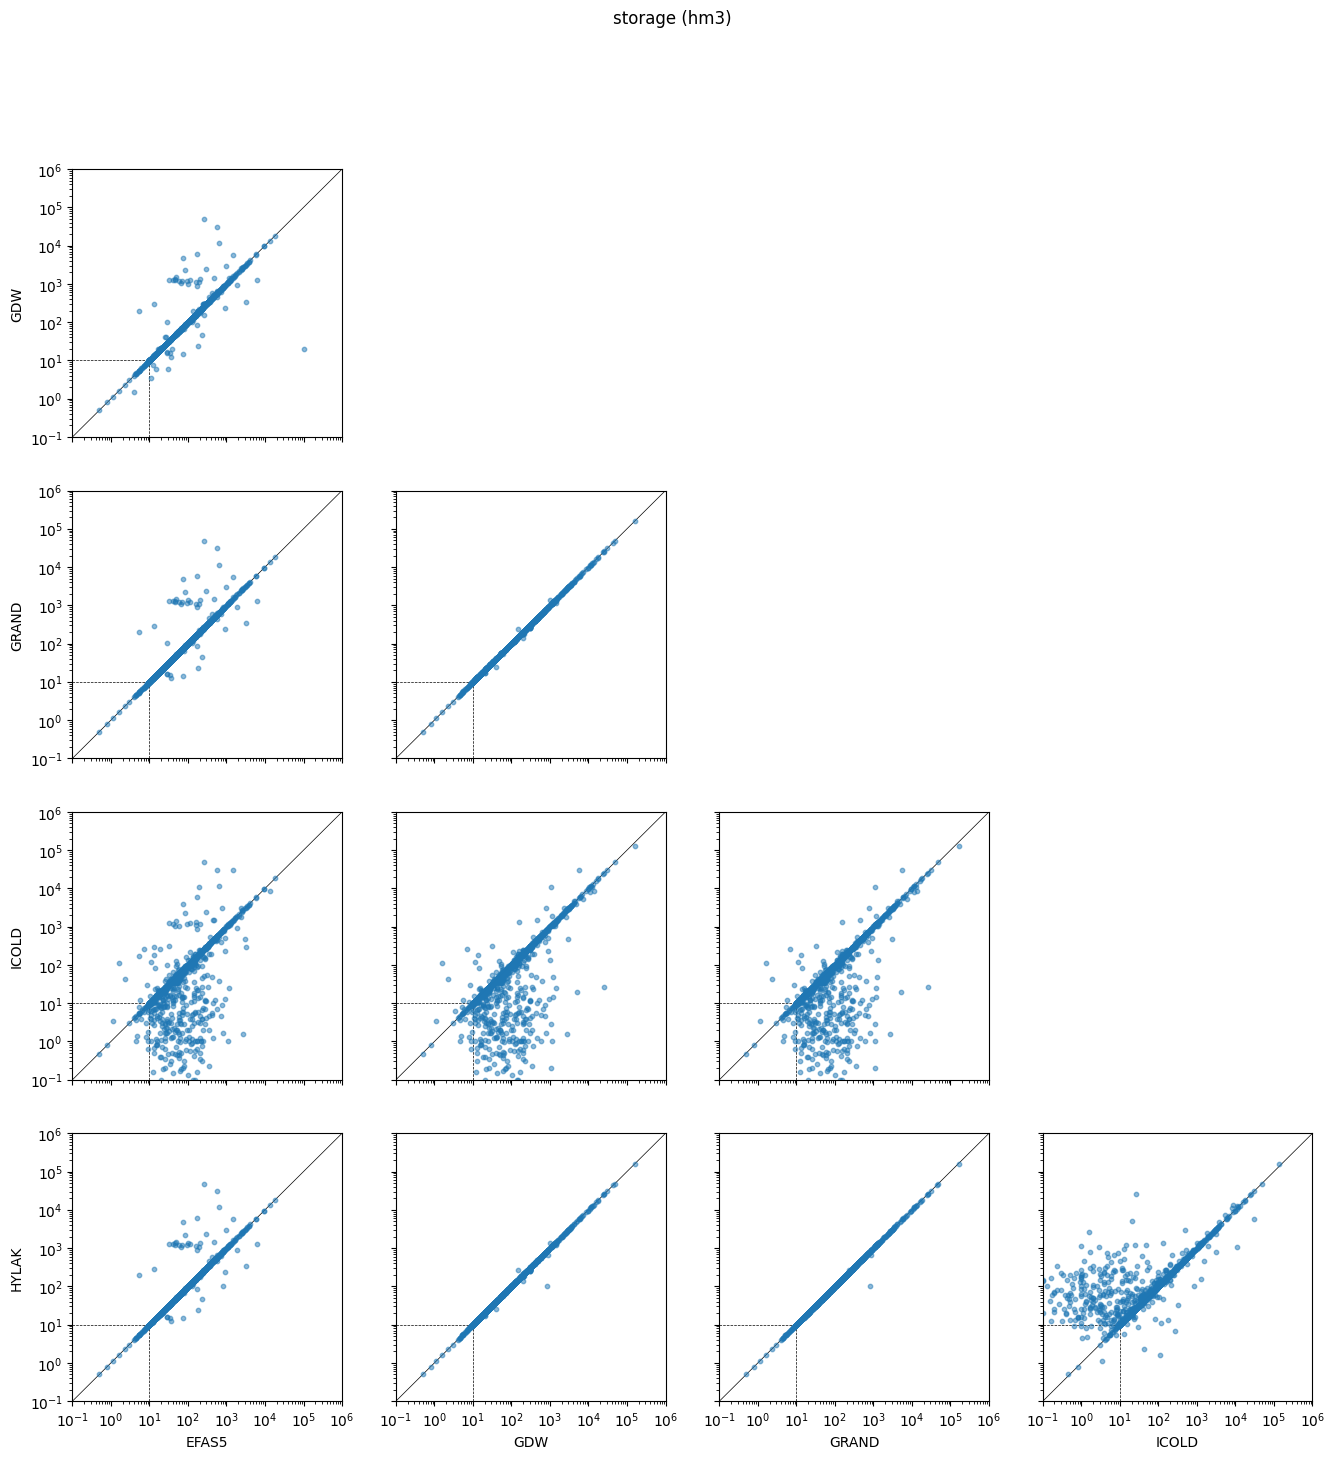

In [23]:
compare_attributes(
    capacity[['EFAS5', 'GDW', 'GRAND', 'ICOLD', 'HYLAK']],
    thr=MIN_VOLUME,
    vmin=1e-1,
    vmax=1e6,
    title='storage (hm3)',
    scale='log'
)
plt.savefig(PATH_PLOTS / 'storage_pairplot.jpg', dpi=300, bbox_inches='tight')

In [24]:
# error = 2
# mask_error = (capacity.GRAND < capacity.EFAS5 / error) | (capacity.GRAND > error * capacity.EFAS5)
# print(mask_error.sum())
# capacity[mask_error]

#### Select values

I have manually checked the large discrepancies between EFAS5 and GRanD. In case of discrepancy, I compare with ICOLD and HydroLakes. It seems like GRanD is a more reliable source, so I will use the value from GRanD whenever possible, if not the value from EFAS5.

In [27]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
capacity.EFAS6 = np.nan
for source in ['GRAND', 'GDW', 'HYLAK', 'ICOLD', 'EFAS5']:
    missing = capacity.EFAS6.isnull()
    mask = capacity[source].notnull()
    capacity.loc[missing & mask, 'EFAS6'] = capacity.loc[missing & mask, source]
    capacity.loc[missing & mask, 'SOURCE'] = source

print('{0} reservoirs are missing the capacity value'.format(capacity.EFAS6.isnull().sum()))
print('{0} reservoirs have a capacity lower or equal than 0'.format((capacity.EFAS6 <= 0).sum()))
print('{0} reservoirs do not comply with the minimum storage of {1} hm3'.format(
    (capacity.EFAS6 < MIN_VOLUME).sum(),
    MIN_VOLUME
))
capacity.SOURCE.value_counts()

0 reservoirs are missing the capacity value
0 reservoirs have a capacity lower or equal than 0
58 reservoirs do not comply with the minimum storage of 10 hm3


SOURCE
GRAND    1520
GDW         9
ICOLD       8
EFAS5       5
Name: count, dtype: int64

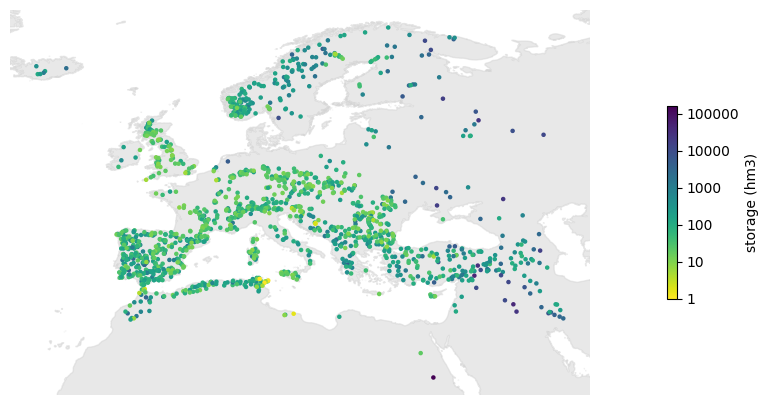

In [28]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=np.log10(capacity.EFAS6),
    cmap='viridis_r',
    s=5,
    vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='storage (hm3)')
ticks = [0, 1, 2, 3, 4, 5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_PLOTS / 'storage_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[capacity.index, ['CAP_MCM', 'CAP_SRC']] = capacity[['EFAS6', 'SOURCE']].values

### Catchment area

In [29]:
catchment = pd.DataFrame(
    index=efas6.index, 
    columns=['EFAS5', 'UPAREA', 'GDW', 'GRAND', 'ICOLD', 'HYLAK', 'EFAS6', 'SOURCE'], 
    dtype=float
)
catchment.SOURCE = catchment.SOURCE.astype(str)

# EFAS5
catchment.loc[efas5.index, 'EFAS5'] = efas5['area']

# upstream area map
catchment.loc[poi6[idx_name], 'UPAREA'] = np.round(uparea.sel({'x': poi6['x'], 'y': poi6['y']}, method='nearest').to_pandas(), 0)

# GDW
catchment.loc[gdw.index, 'GDW'] = gdw.CATCH_SKM

# GRanD
catchment.loc[grand.index, 'GRAND'] = grand.CATCH_SKM

# ICOLD
catchment.loc[icold.index, 'ICOLD'] = icold.Catch_Area

# HydroLakes
catchment.loc[hylak.index, 'HYLAK'] = hylak.Wshd_area

#### Comparison

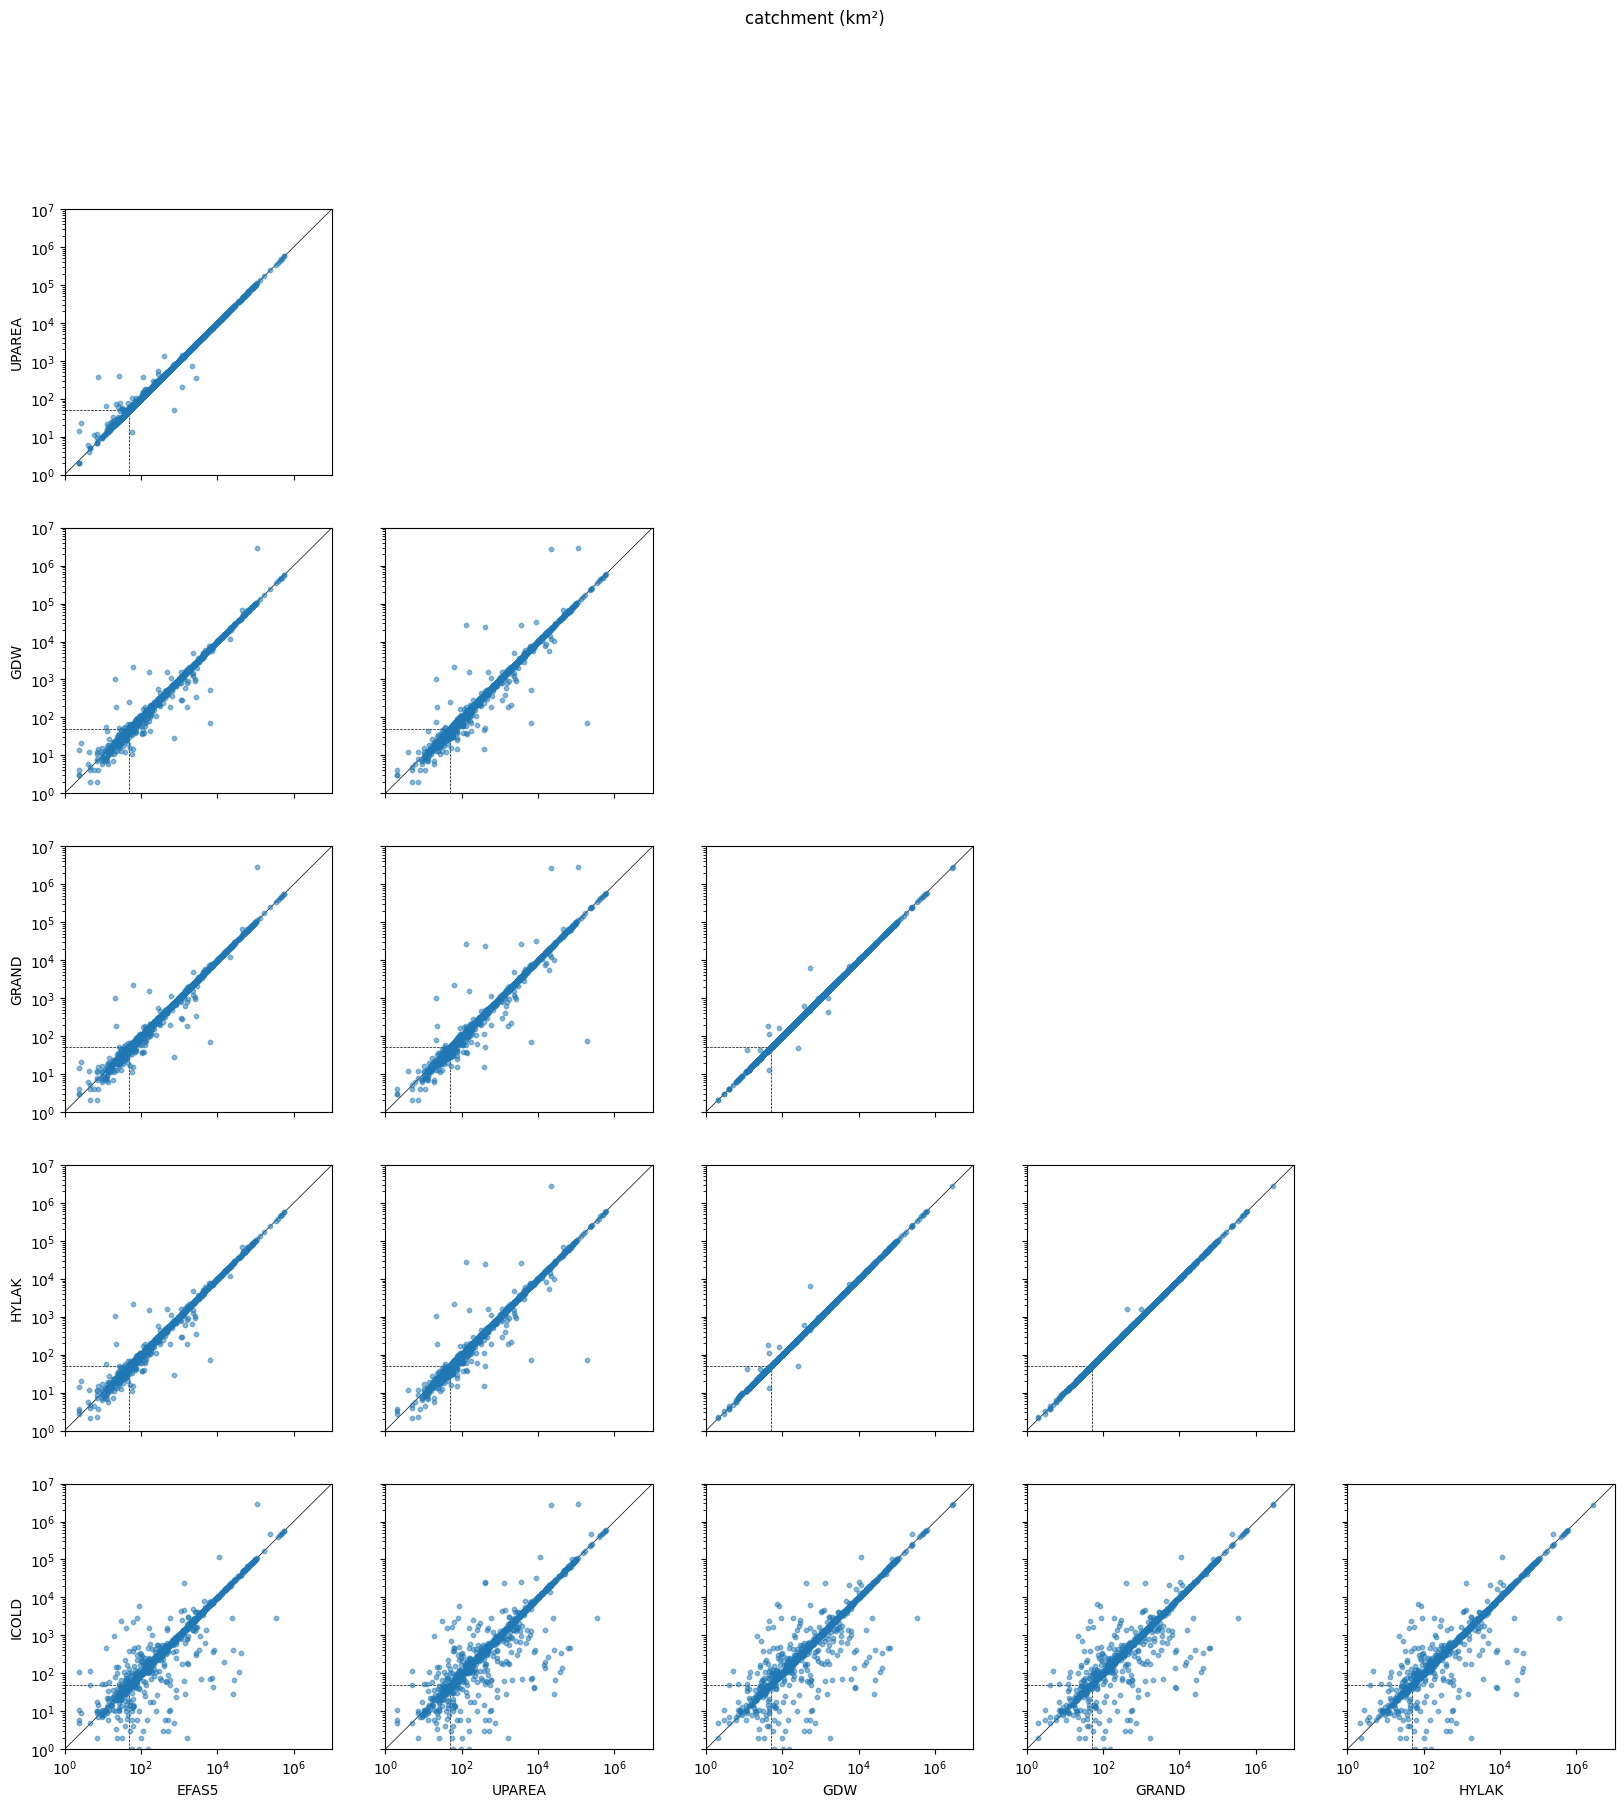

In [30]:
compare_attributes(
    catchment[['EFAS5', 'UPAREA', 'GDW', 'GRAND', 'HYLAK', 'ICOLD']],
    thr=MIN_CATCHMENT,
    vmin=1,
    vmax=1e7,
    title='catchment (km²)'
)
plt.savefig(PATH_PLOTS / 'catchment_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values

Following the procedure applied for the storage capacity, I will use the GRanD value when available.

In [31]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
catchment.EFAS6 = np.nan
for source in ['GRAND', 'GDW', 'HYLAK', 'ICOLD', 'UPAREA', 'EFAS5']:
    missing = catchment.EFAS6.isnull()
    mask = catchment[source].notnull()
    catchment.loc[missing & mask, 'EFAS6'] = catchment.loc[missing & mask, source]
    catchment.loc[missing & mask, 'SOURCE'] = source
    
print('{0} reservoirs are missing the catchment value'.format(catchment.EFAS6.isnull().sum()))
print('{0} reservoirs have catchment lower or equal than 0'.format((catchment.EFAS6 <= 0).sum()))
print('{0} reservoirs do not comply with the minimum catchment area of {1} km²'.format(
    (catchment.EFAS6 < MIN_CATCHMENT).sum(),
    MIN_CATCHMENT
))
catchment.SOURCE.value_counts()

0 reservoirs are missing the catchment value
0 reservoirs have catchment lower or equal than 0
233 reservoirs do not comply with the minimum catchment area of 50 km²


SOURCE
GRAND     1521
GDW         13
UPAREA       4
HYLAK        3
ICOLD        1
Name: count, dtype: int64

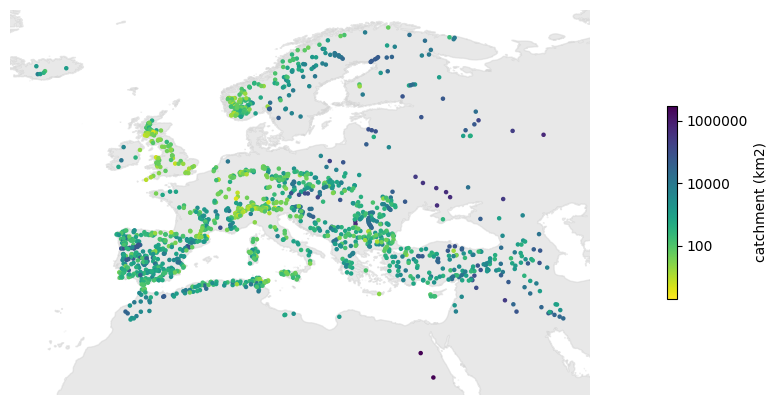

In [32]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=np.log10(catchment.EFAS6),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='catchment (km2)')
ticks = [2, 4, 6]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_PLOTS / 'catchment_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[catchment.index, ['CATCH_SKM', 'CATCH_SRC']] = catchment[['EFAS6', 'SOURCE']].values

### Surface area

In [41]:
area = pd.DataFrame(
    index=efas6.index, 
    columns=['GDW', 'GRAND', 'ICOLD', 'HYLAK', 'EFAS6', 'SOURCE'], 
    dtype=float
)
area.SOURCE = area.SOURCE.astype(str)

# GDW
area.loc[gdw.index, 'GDW'] = gdw.AREA_SKM

# GRanD
area.loc[grand.index, 'GRAND'] = grand.AREA_SKM

# ICOLD
area.loc[icold.index, 'ICOLD'] = icold.Res_Area.values * 1e-3

# HydroLakes
area.loc[hylak.index, 'HYLAK'] = hylak.Lake_area

#### Comparison

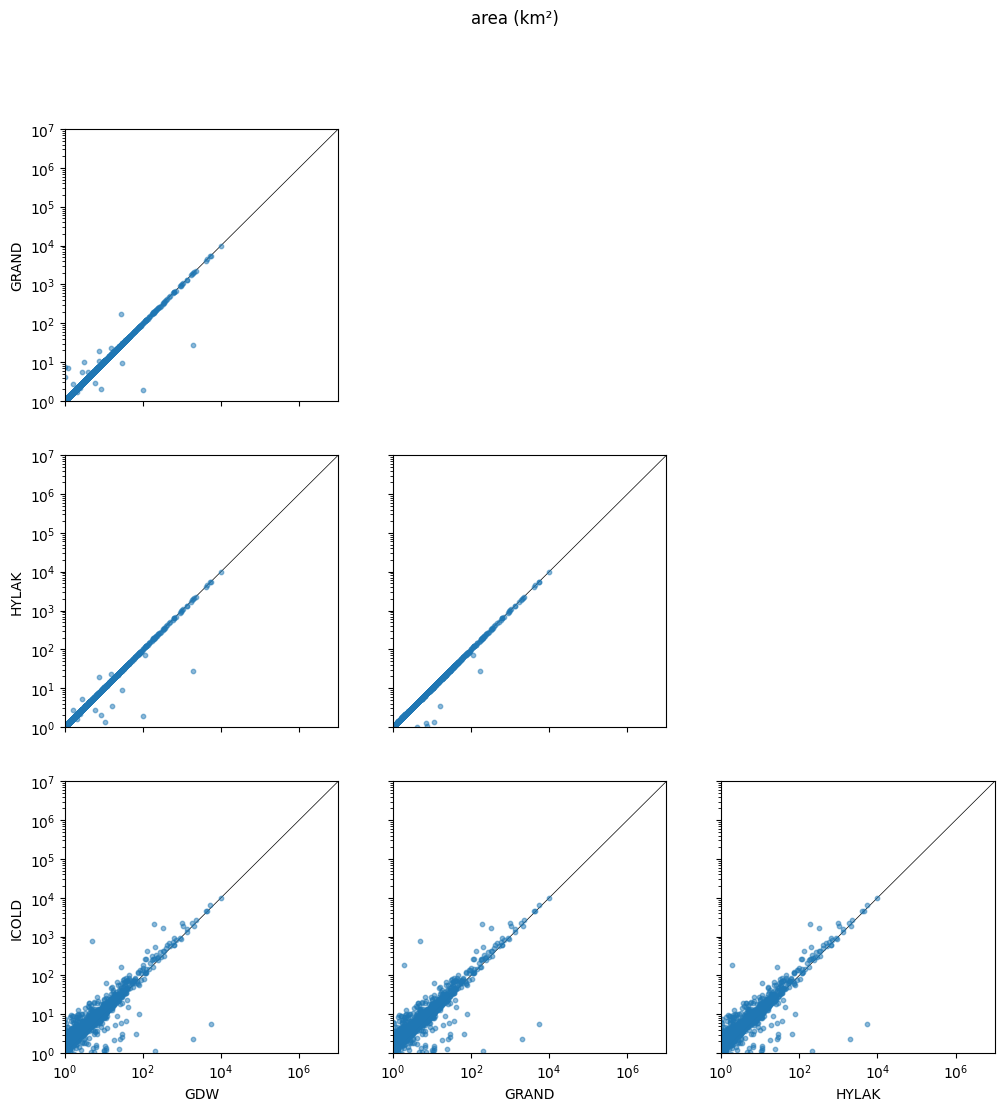

In [42]:
compare_attributes(
    area[['GDW', 'GRAND', 'HYLAK', 'ICOLD']],
    thr=MIN_AREA,
    vmin=1,
    vmax=1e7,
    title='area (km²)'
)
plt.savefig(PATH_PLOTS / 'area_pairplot.jpg', dpi=300, bbox_inches='tight')

There is an error in the units in some ICOLD values.

#### Select values

In [43]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
area.EFAS6 = np.nan
for source in ['GRAND', 'GDW', 'HYLAK', 'ICOLD']:
    missing = area.EFAS6.isnull()
    mask = area[source].notnull()
    area.loc[missing & mask, 'EFAS6'] = area.loc[missing & mask, source]
    area.loc[missing & mask, 'SOURCE'] = source
    
print('{0} reservoirs are missing the area value'.format(area.EFAS6.isnull().sum()))
print('{0} reservoirs have an area lower or equal than 0 km2'.format((area.EFAS6 <= 0).sum()))
area.SOURCE.value_counts()

4 reservoirs are missing the area value
0 reservoirs have an area lower or equal than 0 km2


SOURCE
GRAND    1517
GDW        10
ICOLD       7
nan         4
HYLAK       4
Name: count, dtype: int64

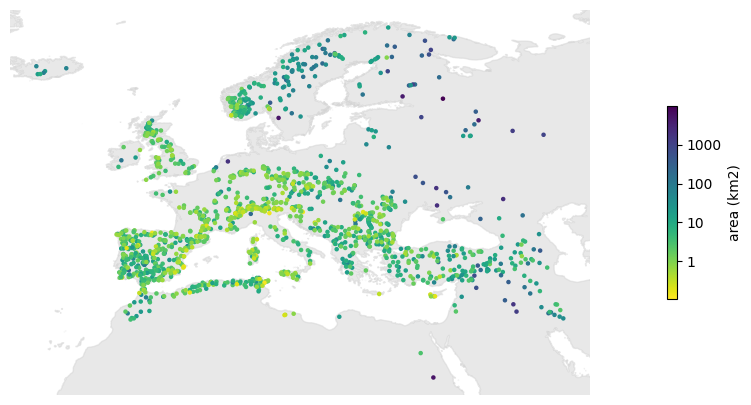

In [44]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=np.log10(area.EFAS6),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='area (km2)')
ticks = [0, 1, 2, 3]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_PLOTS / 'area_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[area.index, ['AREA_SKM', 'AREA_SRC']] = area[['EFAS6', 'SOURCE']].values

### Mean inflow

I do not include the values reported in HydroLakes (`Dis_avg`) because they are identical to those in GRanD.

In [47]:
dis_avg = pd.DataFrame(
    index=efas6.index, 
    columns=['EFAS5', 'NAT_FLOW', 'LTR', 'GDW', 'GRAND', 'EFAS6', 'SOURCE'], 
    dtype=float
)
dis_avg.SOURCE = dis_avg.SOURCE.astype(str)

# EFAS5 reservoir parameter
dis_avg.loc[efas5.index, 'EFAS5'] = efas5.normq

# EFAS5 natural flow
dis_nat_avg = dis_nat.mean('time').to_pandas()
dis_avg.loc[dis_nat_avg.index, 'NAT_FLOW'] = dis_nat_avg
del dis_nat_avg

# EFAS5 long-run average
pbar = tqdm(efas6.geometry.items(), total=len(efas6))
for ID, point in pbar:
    dis_avg.loc[ID, 'LTR'] = dis_avg_ltr.sel(x=point.x, y=point.y, method='nearest').item()

# GDW
dis_avg.loc[gdw.index, 'GDW'] = gdw.DIS_AVG_LS * 1e-3

# GRanD
dis_avg.loc[grand.index, 'GRAND'] = grand.DIS_AVG_LS * 1e-3

# HydroLakes
dis_avg.loc[hylak.index, 'HYLAK'] = hylak.Dis_avg

  0%|          | 0/1542 [00:00<?, ?it/s]

#### Comparison

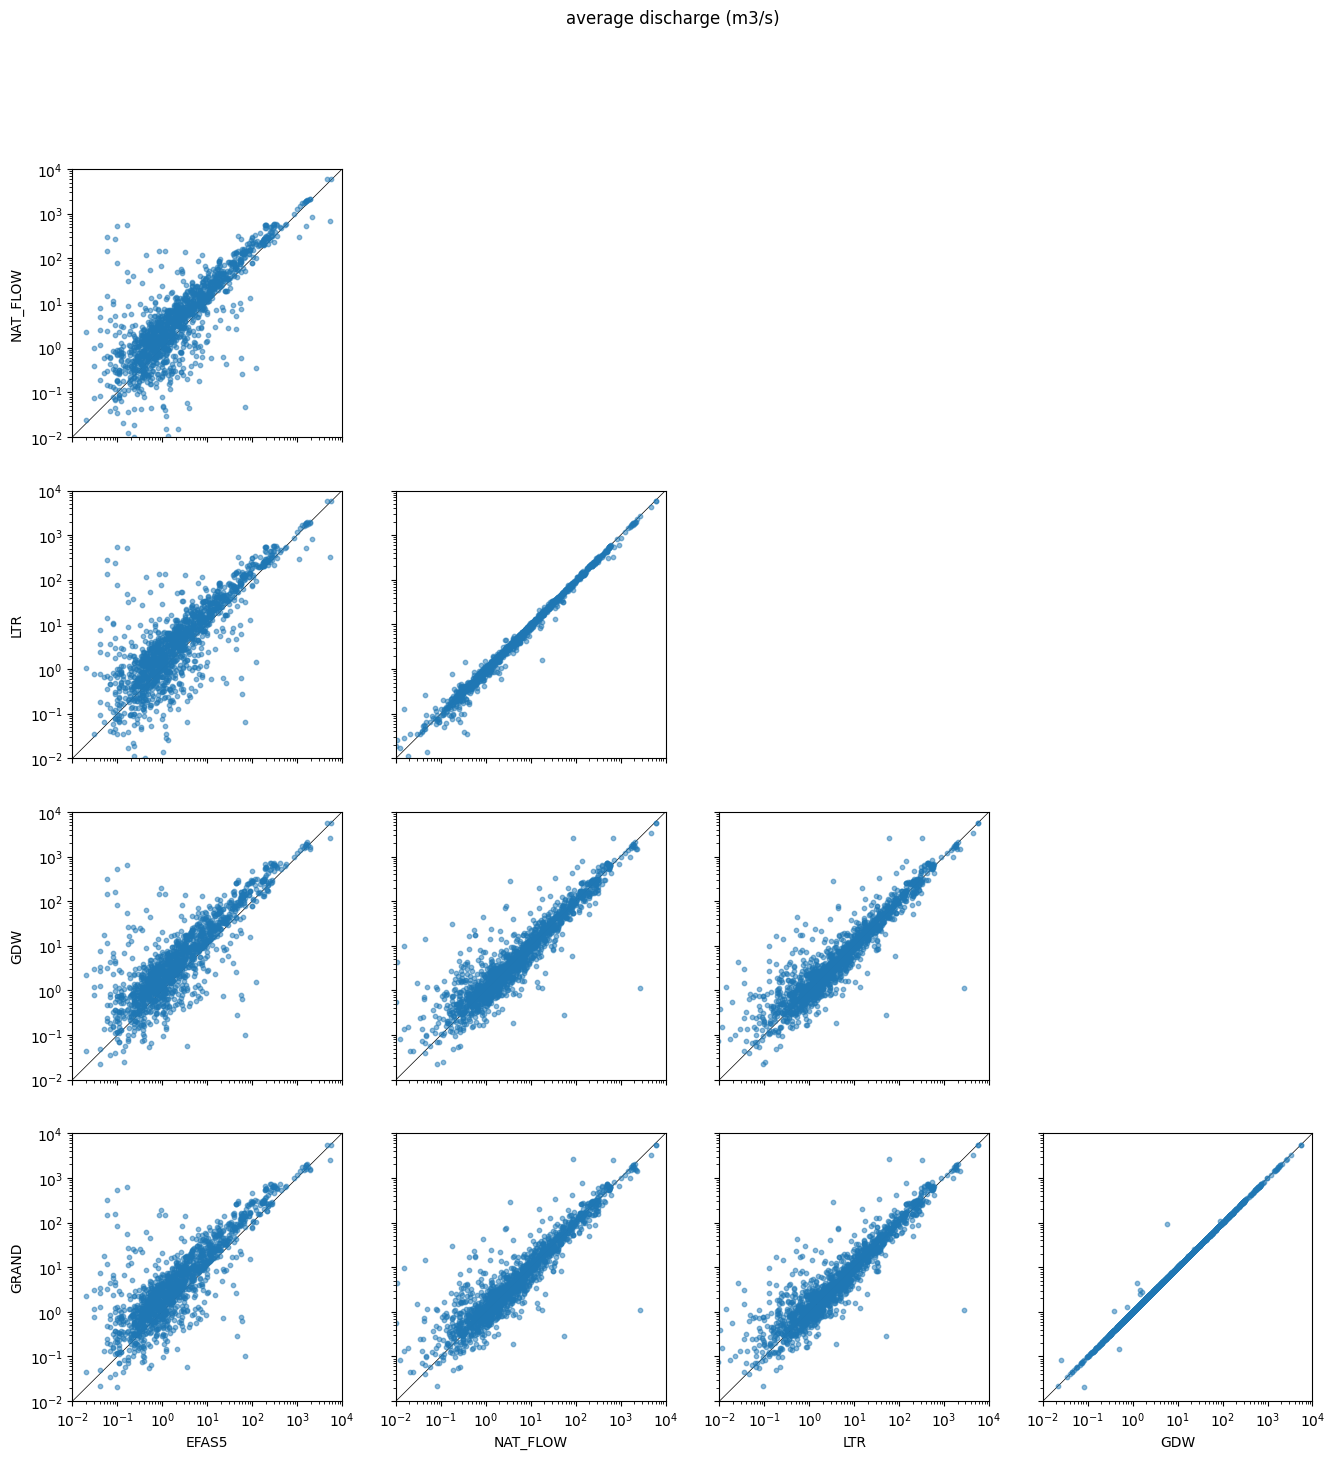

In [48]:
compare_attributes(
    dis_avg[['EFAS5', 'NAT_FLOW', 'LTR', 'GDW', 'GRAND']],
    thr=0,
    vmin=0.01,
    vmax=1e4,
    title='average discharge (m3/s)'
)
plt.savefig(
    PATH_PLOTS / 'dis_avg_pairplot.jpg', 
    dpi=300, 
    bbox_inches='tight'
)

Some reservoirs have average flow surprisingly small. 390 reservoirs have a "natural" average inflow below 1 m3/s. That number was 534 for EFAS5, and 355 in GRanD. These low values indirectly affect the reservoirs that will be modelled as lakes, as the degree of regulation is the reservoir volume divided by the average inflow.

#### Select values
Despite the previous concern, I will use in all cases the naturalised average inflow.

380 reservoirs have an average inflow below 1 m3/s


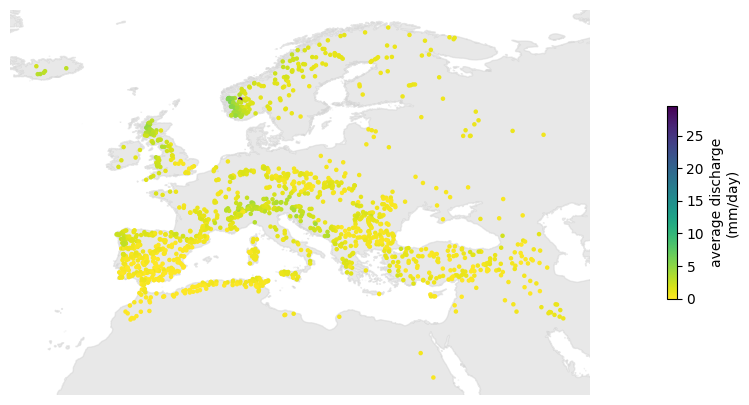

In [49]:
# select values from the EFAS5 naturalised run
dis_avg.EFAS6 = dis_avg.NAT_FLOW
dis_avg.SOURCE = 'EFAS5_nat'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(
    cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), 
    alpha=.5, 
    zorder=0
)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=dis_avg.EFAS6 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='average discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_PLOTS / 'dis_avg_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[dis_avg.index, 'DISAVG_CMS'] = dis_avg['EFAS6'].round(1).values

print('{0} reservoirs have an average inflow below 1 m3/s'.format((efas6.DISAVG_CMS < 1).sum()))

### Degree of regulation

The degree of regulation is the amount of annual inflow that the reservoir can store. I'll cap this value to 10,000 years (same as GRanD does), since it's not feasible that a reservoir was designed to store that amount of water.

In [56]:
dor = pd.DataFrame(
    index=efas6.index, 
    columns=['EFAS6', 'GDW', 'GRAND', 'HYLAK'], 
    dtype=float
)

# EFAS6
dor['EFAS6'] = np.minimum(efas6.CAP_MCM * 1e6 / (efas6.DISAVG_CMS  * 24 * 3600 * 365), 1e4)

# GDW
dor.loc[gdw.index, 'GDW'] = gdw.DOR_PC

# GRanD
dor.loc[grand.index, 'GRAND'] = grand.DOR_PC

# HydroLakes
dor.loc[hylak.index, 'HYLAK'] = hylak.dor_pc_pva

#### Comparison

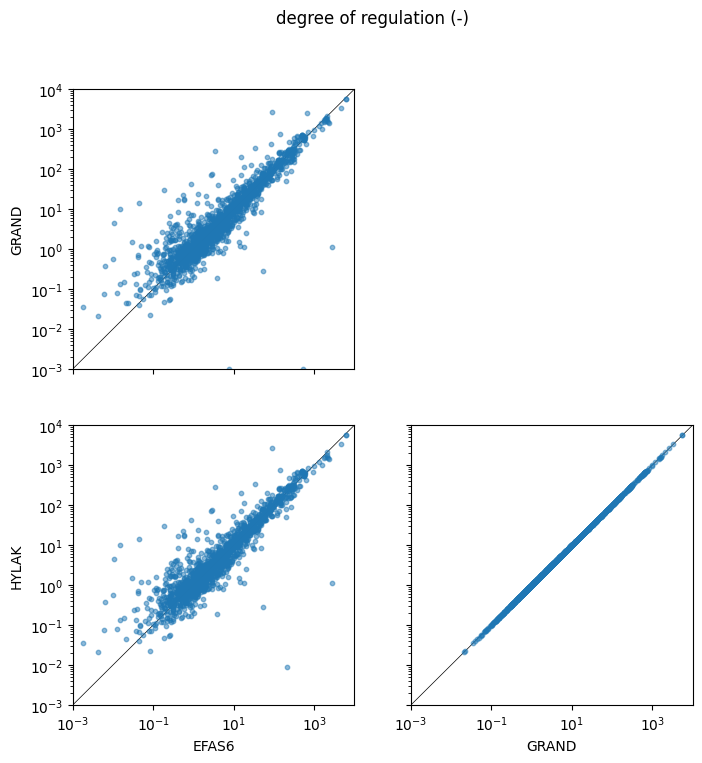

In [57]:
compare_attributes(
    dis_avg[['EFAS6', 'GRAND', 'HYLAK']],
    thr=0,
    vmin=0.001,
    vmax=1e4,
    title='degree of regulation (-)'
)
plt.savefig(PATH_PLOTS / 'dor_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values

I will use the values obtained from the attributes in EFAS6.

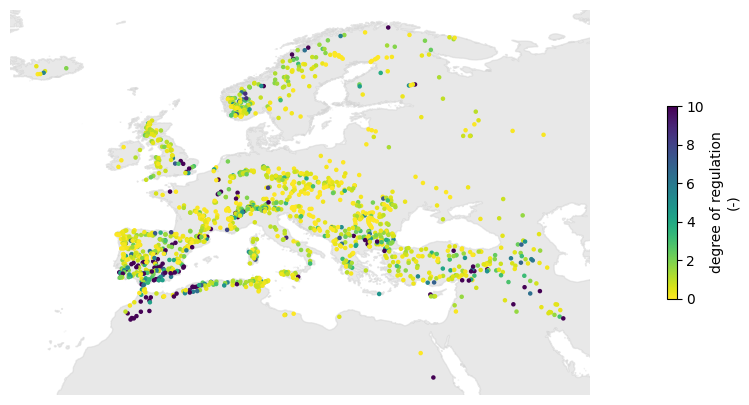

In [58]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(
    cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), 
    alpha=.5, 
    zorder=0
)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=dor.EFAS6,
    cmap='viridis_r',
    s=5,
    vmin=0,
    vmax=10
)
cbar = plt.colorbar(sct, shrink=.5, label='degree of regulation\n(-)')
plt.axis('off');
plt.savefig(PATH_PLOTS / 'dor_map.jpg', dpi=300, bbox_inches='tight')

In [59]:
efas6['DOR'] = dor.EFAS6.round(3)

print('{0} reservoirs do not comply with the minimum degree of regulation {1}'.format(
    (efas6.DOR < MIN_DOR).sum(),
    MIN_DOR)
)
print('{0} reservoirs have a degree of regulation larger than 10 years'.format((efas6.DOR > 10).sum()))

218 reservoirs do not comply with the minimum degree of regulation 0.08
100 reservoirs have a degree of regulation larger than 10 years


There are problems in the computation of the degree of regulation, inherited either from the reservoir storage or the average inflow. It's not realistic that 100 reservoirs were designed to store 10 years of inflow.

### 100-year return period

In [60]:
dis_100 = pd.DataFrame(
    index=efas6.index, 
    columns=['EFAS5', 'NAT_FLOW', 'LTR', 'EFAS6', 'SOURCE'], 
    dtype=float
)
dis_100.SOURCE = dis_100.SOURCE.astype(str)

# EFAS5
dis_100.loc[efas5.index, 'EFAS5'] = efas5.ndq

# EFAS5 natural flow
dis_nat_df = dis_nat.to_pandas().transpose()
for gdw_id in tqdm(dis_nat_df.columns, desc='EFAS-5 natural run'):
    dis_100.loc[gdw_id, 'NAT_FLOW'] = return_period(dis_nat_df[gdw_id], T=100)

# EFAS5 long-run 100 year return period
pbar = tqdm(efas6.geometry.items(), total=len(efas6), desc='EFAS-5 long run')
for ID, point in pbar:
    dis_100.loc[ID, 'LTR'] = dis_100_ltr.sel(x=point.x, y=point.y, method='nearest').item()

EFAS-5 natural run:   0%|          | 0/1542 [00:00<?, ?it/s]

C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\scipy\stats\_continuous_distns.py:4351: RuntimeWarning: overflow encountered in cast
  sdata = -data / scale
C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\scipy\stats\_continuous_distns.py:4353: RuntimeWarning: overflow encountered in cast
  return data.mean() - wavg - scale
C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\scipy\stats\_continuous_distns.py:4351: RuntimeWarning: invalid value encountered in divide
  sdata = -data / scale
C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\scipy\stats\_continuous_distns.py:4325: RuntimeWarning: invalid value encountered in divide
  return -scale * (sc.logsumexp(-data / scale) - np.log(len(data)))
C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\scipy\stats\_continuous_distns.py:4351: RuntimeWarning: overflow encountered in cast
  sdata = -data / scale
C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\scipy\stats\_continuous_distns.py:4353: RuntimeWarning: overflow encountered in

EFAS-5 long run:   0%|          | 0/1542 [00:00<?, ?it/s]

#### Comparison

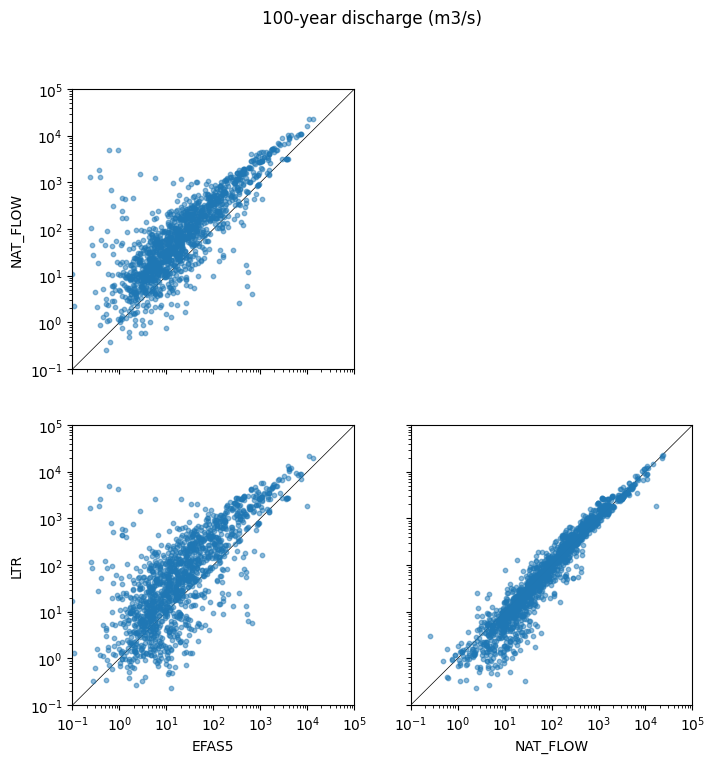

In [61]:
compare_attributes(
    dis_100[['EFAS5', 'NAT_FLOW', 'LTR']],
    thr=0,
    vmin=0.1,
    vmax=1e5,
    title='100-year discharge (m3/s)',
    # scale='linear'
)
plt.savefig(PATH_PLOTS / 'dis_100_pairplot.jpg', dpi=300, bbox_inches='tight');

There is a great difference in the values of reservoir 1540 (GRanD 6851), a reservoir in the Nile.

In [62]:
(dis_100.NAT_FLOW / dis_100.EFAS5).median()

np.float64(3.121983590733591)

The EFAS5 non-damaging flow must have been the 97th percentile of a previous EFAS run, so it's not exactely the 100-year return period computed here. The median difference between the 100-year inflow and the EFAS5 non-damaging flow is 3.2. Bear in mind that the flood outflow in the Hanazaki routine is by default 30% of the 100-year inflow, therefore overall similar values.

#### Select values

250 reservoirs have an 100-year inflow below 10 m3/s


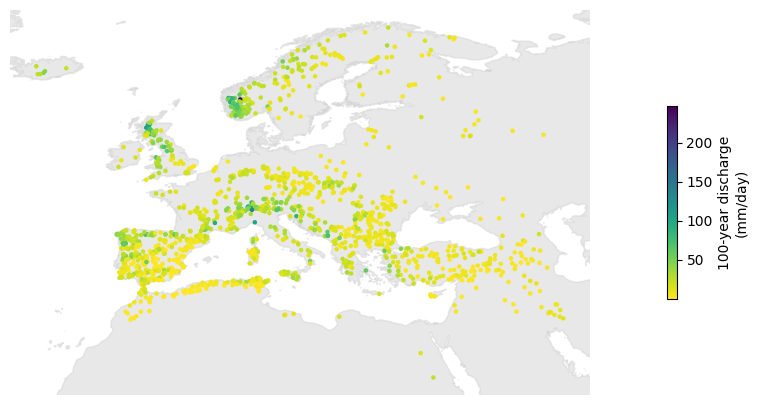

In [63]:
# select values from the EFAS5 naturalised run
dis_100.EFAS6 = dis_100.NAT_FLOW
dis_100.SOURCE = 'EFAS5_nat'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(
    cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), 
    alpha=.5, 
    zorder=0
)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=dis_100.EFAS6 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='100-year discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_PLOTS / 'dis_100_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[dis_100.index, 'DIS100_CMS'] = dis_100['EFAS6'].round(1).values

print('{0} reservoirs have an 100-year inflow below 10 m3/s'.format((efas6.DIS100_CMS < 10).sum()))

### Environment flow

In [64]:
dis_env = pd.DataFrame(
    index=efas6.index, 
    columns=['EFAS5', 'NAT_FLOW', 'D2', 'EFAS6', 'SOURCE'], 
    dtype=float
)
dis_env.SOURCE = dis_env.SOURCE.astype(str)

# EFAS5
dis_env.loc[efas5.index, 'EFAS5'] = efas5.minq

# EFAS5 natural flow
dis_env['NAT_FLOW'] = dis_nat.sel(time=slice('2000-01-01', None)).quantile(.1, dim='time').to_pandas()

# EFAS5 naturalised run
for ID, point in efas6.geometry.items():
    dis_env.loc[ID, 'D2'] = dis_env_nat.sel(lon=point.x, lat=point.y, method='nearest').item()

#### Comparison

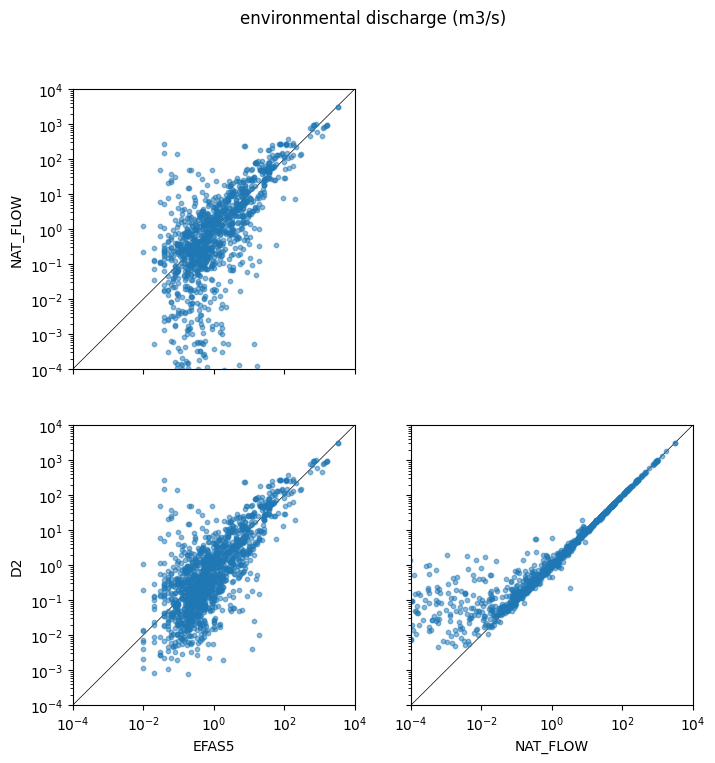

In [65]:
compare_attributes(
    dis_env[['EFAS5', 'NAT_FLOW', 'D2']],
    thr=0,
    vmin=1e-4,
    vmax=1e4,
    title='environmental discharge (m3/s)',
    # scale='linear'
)
plt.savefig(PATH_PLOTS / 'dis_env_pairplot.jpg', dpi=300, bbox_inches='tight');

#### Select values

I will select the values extracted from the D2 map, as it limits extremely low values.

373 reservoirs have an environmental flow below 0.1 m3/s


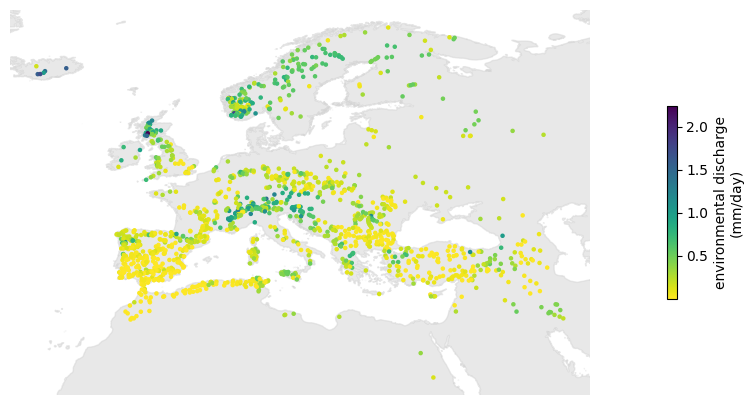

In [66]:
# select values from the EFAS5 naturalised run
dis_env.EFAS6 = dis_env.D2
dis_env.SOURCE = 'EFAS5_nat'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(
    cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), 
    alpha=.5, 
    zorder=0
)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=dis_env.EFAS6 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='environmental discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_PLOTS / 'dis_env_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[dis_env.index, 'DISENV_CMS'] = dis_env['EFAS6'].round(4).values

print('{0} reservoirs have an environmental flow below 0.1 m3/s'.format((efas6.DISENV_CMS < 0.1).sum()))

There are very low values of environmental flow.

## Export

### Excel file

In [67]:
# copy efas6 as main source
reservoirs = efas6.copy()
reservoirs.sort_index(inplace=True)

# LISFLOOD coordinates
reservoirs['LisfloodX'] = reservoirs.geometry.x
reservoirs['LisfloodY'] = reservoirs.geometry.y

# source of discharge data
reservoirs['DIS_SRC'] = 'EFAS5_natflow'

# add data from GDW
gdw_cols = [
    'RES_NAME', 
    'DAM_NAME', 
    'RIVER', 
    'MAIN_BASIN', 
    'COUNTRY', 
    'YEAR_DAM', 
    'REM_YEAR', 
    'LONG_RIV', 
    'LAT_RIV'
]
gdw_ids = gdw.index.intersection(reservoirs.index)
reservoirs.loc[gdw_ids, gdw_cols] = gdw.loc[gdw_ids, gdw_cols]
reservoirs[['YEAR_DAM', 'REM_YEAR']] = reservoirs[['YEAR_DAM', 'REM_YEAR']].astype(float).astype('Int64')

# add info from EFAS5
for col in ['COUNTRY', 'DAM_NAME']:
    ids = reservoirs[reservoirs[col].isnull() & reservoirs.RES_ID.notnull()].index
    reservoirs.loc[ids, col] = efas5.loc[ids, col]

# reorder and rename columns
cols = ['RES_ID', 'GDW_ID', 'GRAND_ID', 'HYLAK_ID', 'ICOLD_ID'] + \
    gdw_cols + \
    ['LisfloodX', 'LisfloodY',
     'CAP_MCM', 'CAP_SRC', 'CATCH_SKM', 'CATCH_SRC', 'AREA_SKM', 'AREA_SRC', 'DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS', 'DIS_SRC', 'DOR',
     'geometry']
cols.remove(idx_name)
reservoirs = reservoirs[cols]

# reservoirs that will be modelled as reservoirs
mask_res = (reservoirs.DOR >= MIN_DOR) | ((reservoirs.index > 50000) & (reservoirs.index < 51000)) | (reservoirs.AREA_SKM.isnull())
print('{0} reservoirs will be modelled as lakes'.format((~mask_res).sum()))

# save table of reservoirs as Excel
xls_file = PATH_OUT / 'efas6_reservoirs_{0}.xlsx'.format(datetime.now().strftime('%Y%m%d'))
with pd.ExcelWriter(xls_file, engine='openpyxl') as writer:
    # Reservoirs in EFAS6 (as reservoirs)
    reservoirs[mask_res].drop('geometry', axis=1).to_excel(writer, sheet_name='as_reservoirs', float_format='%.4f')
    
    # Reservoirs modeled as lakes in EFAS6 (as lakes)
    reservoirs[~mask_res].drop('geometry', axis=1).to_excel(writer, sheet_name='as_lakes', float_format='%.4f')
print(f'Reservoir Excel table saved in : {xls_file}')

214 reservoirs will be modelled as lakes
Reservoir Excel table saved in : Z:\nahaUsers\casadje\EFASv6\reservoirs\tables\efas6_reservoirs_20250825.xlsx


### TXT tables

In [78]:
# path where tables will be saved
PATH_TABLES = PATH_EFAS6 / 'tables'
PATH_TABLES.mkdir(parents=False, exist_ok=True)
print(f'The TXT tables will be saved in {PATH_TABLES}')
file_name = 'reservoirs_efas6'
date_str = datetime.now().strftime('%Y%m%d')

# filter reservoirs to be modelled as reservoirs
res = reservoirs[mask_res].sort_index()
# res = pd.read_excel(
#     list(PATH_OUT.glob('efas6_reservoirs_*.xlsx'))[-1], 
#     sheet_name='as_reservoirs', 
#     index_col='FID'
# ).sort_index()

# table reservoir capacity
txt_file = PATH_TABLES / '{0}_capacity_{1}.txt'.format(file_name, date_str)
(res.CAP_MCM * 1e6).to_csv(txt_file, sep='\t', header=None, float_format='%.0f')
print(f'\t{txt_file.name}')

# table environmental flow
txt_file = PATH_TABLES / '{0}_env_flow_{1}.txt'.format(file_name, date_str)
res.DISENV_CMS.round(3).to_csv(txt_file, sep='\t', header=None)
print(f'\t{txt_file.name}')

# table average discharge
txt_file = PATH_TABLES / '{0}_avg_inflow_{1}.txt'.format(file_name, date_str)
res.DISAVG_CMS.round(1).to_csv(txt_file, sep='\t', header=None )
print(f'\t{txt_file.name}')

# table 100-year discharge
txt_file = PATH_TABLES / '{0}_100yr_inflow_{1}.txt'.format(file_name, date_str)
res.DIS100_CMS.round(1).to_csv(txt_file, sep='\t', header=None)
print(f'\t{txt_file.name}')

# years of construction and demolition
map_years = {
    'YEAR_DAM': 'CONSTR_YEAR', 
    'REM_YEAR': 'DEMOL_YEAR'
}
txt_file = PATH_TABLES / '{0}_years_{1}.csv'.format(file_name, date_str)
res[map_years.keys()].rename(columns=map_years).to_csv(txt_file)
print(f'\t{txt_file.name}')

The TXT tables will be saved in Z:\nahaUsers\casadje\EFASv6\tables
	reservoirs_efas6_capacity_20250825.txt
	reservoirs_efas6_env_flow_20250825.txt
	reservoirs_efas6_avg_inflow_20250825.txt
	reservoirs_efas6_100yr_inflow_20250825.txt
	reservoirs_efas6_years_20250825.csv


### NetCDF map

In [74]:
# path where maps will be saved
PATH_MAPS = PATH_EFAS6 / 'static_maps'
PATH_MAPS.mkdir(parents=False, exist_ok=True)
print(f'Static maps will be saved in {PATH_MAPS}')

# define file name and attributes
nc_file = PATH_MAPS / '{0}_01min_{1}.nc'.format(
    file_name, 
    datetime.now().strftime('%Y%m%d')
)
attrs = {
    'contributors': 'Juliana Disperati <juliana.disperati@ext.ec.europa.eu>',
    'creator': 'Jesús Casado Rodríguez <jesus.casado-rodriguez@ec.europa.eu>',
    'creator_name': 'casadje',
    'history': ('Created {0}'.format(datetime.now().strftime("%a %b %e %H:%M:%S %Y"))),
    'history_of_appended_files': '',
    'institution': 'Joint Research Centre - European Commission',
    'long_name': 'map of reservoir IDs',
    'name': 'reservoirs',
    'references': 'https://www.globaldamwatch.org/grand',
}

# create NetCDF file
create_lisflood_nc(
    template=PATH_EFAS5 / 'static_maps' / 'template_European_01min.nc',
    points=res,
    output=nc_file,
    attrs=attrs,
    crs='EPSG:4326'
)

Static maps will be saved in Z:\nahaUsers\casadje\EFASv6\static_maps


  0%|          | 0/1328 [00:00<?, ?it/s]

Created file Z:\nahaUsers\casadje\EFASv6\static_maps\reservoirs_efas6_01min_20250825.nc


In [58]:
# export as point shapefile
# res.to_file(PATH_OUT / 'reservoirs_efas6_{0}.shp'.format(datetime.now().strftime('%Y%m%d')))